<a id="title_ID"></a>
# JWST Pipeline Validation Notebook: skymatch with MIRI

<span style="color:red"> **Instruments Affected**</span>: MIRI, NIRCam 


Tested on MIRI Simulated data

### Table of Contents
<div style="text-align: left"> 

<br>  [Introduction](#intro_ID) <br> [Imports](#imports_ID) <br> [Set up association files](#associations_ID) <br> [Insert outliers](#outliers_ID) <br> [Run Pipeline](#pipeline_ID) 


</div>

<a id="intro_ID"></a>
## Introduction

This notebook processes level 2 images through the calwebb_image3 skymatch and resample steps and examines outputs for different sky method parameters.

1) Set up data path and image list file.

2) Set up association files.

3) Modify average backgrould level of input images.

4) Run skymatch step on images.

5) Run skymatch and resample for each skymethod parameter (local, global, match, global+match). 

6) Testing other parameters (nclip, usigma, lsigma, lower, upper, skystat). (Still TBD.)


These steps are set up with simulated MIRI F560W data of the LMC astrometric field. The notebook removes the astrometric field and replaces the field with noise images to help the pipeline testers have a better visualization of what the pipeline is doing with each set of parameters. 

This notebook has also been modified to test how skymatch and resample work together (with subtract=True indicating that the subtraction is done in the skymatch step and subtract=False indicating that the subtraction is done in the resample step). There are displays of the combined noise image to see how well the backgrounds were subtracted in the full combined image.

The pipeline documentation can be found here: https://jwst-pipeline.readthedocs.io/en/latest/jwst/skymatch/README.html

The pipeline code is available on GitHub: https://github.com/spacetelescope/jwst/tree/master/jwst/skymatch

Authors: T. Temim and M. Cracraft
Last modified: 01/18/2022

### Set up temporary directory and CRDS options

In [1]:
# Create a temporary directory to hold notebook output, and change the working directory to that directory.
from tempfile import TemporaryDirectory
import os
data_dir = TemporaryDirectory()
os.chdir(data_dir.name)

In [2]:
# Set up CRDS options

import os
if "CRDS_CACHE_TYPE" in os.environ:
    if os.environ['CRDS_CACHE_TYPE'] == 'local':
        os.environ['CRDS_PATH'] = os.path.join(os.environ['HOME'], 'crds', 'cache')
    elif os.path.isdir(os.environ['CRDS_CACHE_TYPE']):
        os.environ['CRDS_PATH'] = os.environ['CRDS_CACHE_TYPE']

<a id="imports_ID"></a>
### Set up import statements

The following packages are needed to run this notebook:
* jwst to run the pipeline 
* matplotlib to plot
* ci_watson to retrieve data from artifactory


In [3]:
import pytest
from astropy.io import fits
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import jwst
import json
from jwst.skymatch import skymatch
from jwst.resample import ResampleStep
from jwst.pipeline import Image3Pipeline
from jwst.skymatch.skyimage import SkyImage
from jwst.associations.lib.rules_level3_base import DMS_Level3_Base
from jwst.associations import asn_from_list
from jwst import datamodels
from jwst.datamodels import ImageModel
from matplotlib import rcParams
from ci_watson.artifactory_helpers import get_bigdata

### Print pipeline version number

In [4]:
jwst.__version__ 

'1.7.2'

### Retrieve data from Artifactory

In [5]:
input_file1 = get_bigdata('jwst_validation_notebooks',
                     'validation_data',
                     'outlier_detection',
                     'outlier_detection_miri_test', 
                     'det_image_seq1_MIRIMAGE_F560Wexp1_cal.fits')
input_file2 = get_bigdata('jwst_validation_notebooks',
                     'validation_data',
                     'outlier_detection',
                     'outlier_detection_miri_test', 
                     'det_image_seq2_MIRIMAGE_F560Wexp1_cal.fits')
input_file3 = get_bigdata('jwst_validation_notebooks',
                     'validation_data',
                     'outlier_detection',
                     'outlier_detection_miri_test', 
                     'det_image_seq3_MIRIMAGE_F560Wexp1_cal.fits')
input_file4 = get_bigdata('jwst_validation_notebooks',
                     'validation_data',
                     'outlier_detection',
                     'outlier_detection_miri_test', 
                     'det_image_seq4_MIRIMAGE_F560Wexp1_cal.fits')

In [6]:
input_files=[]
input_files=[input_file1,input_file2,input_file3,input_file4]

imlist1=['det_image_seq1_MIRIMAGE_F560Wexp1_cal.fits','det_image_seq2_MIRIMAGE_F560Wexp1_cal.fits','det_image_seq3_MIRIMAGE_F560Wexp1_cal.fits','det_image_seq4_MIRIMAGE_F560Wexp1_cal.fits']

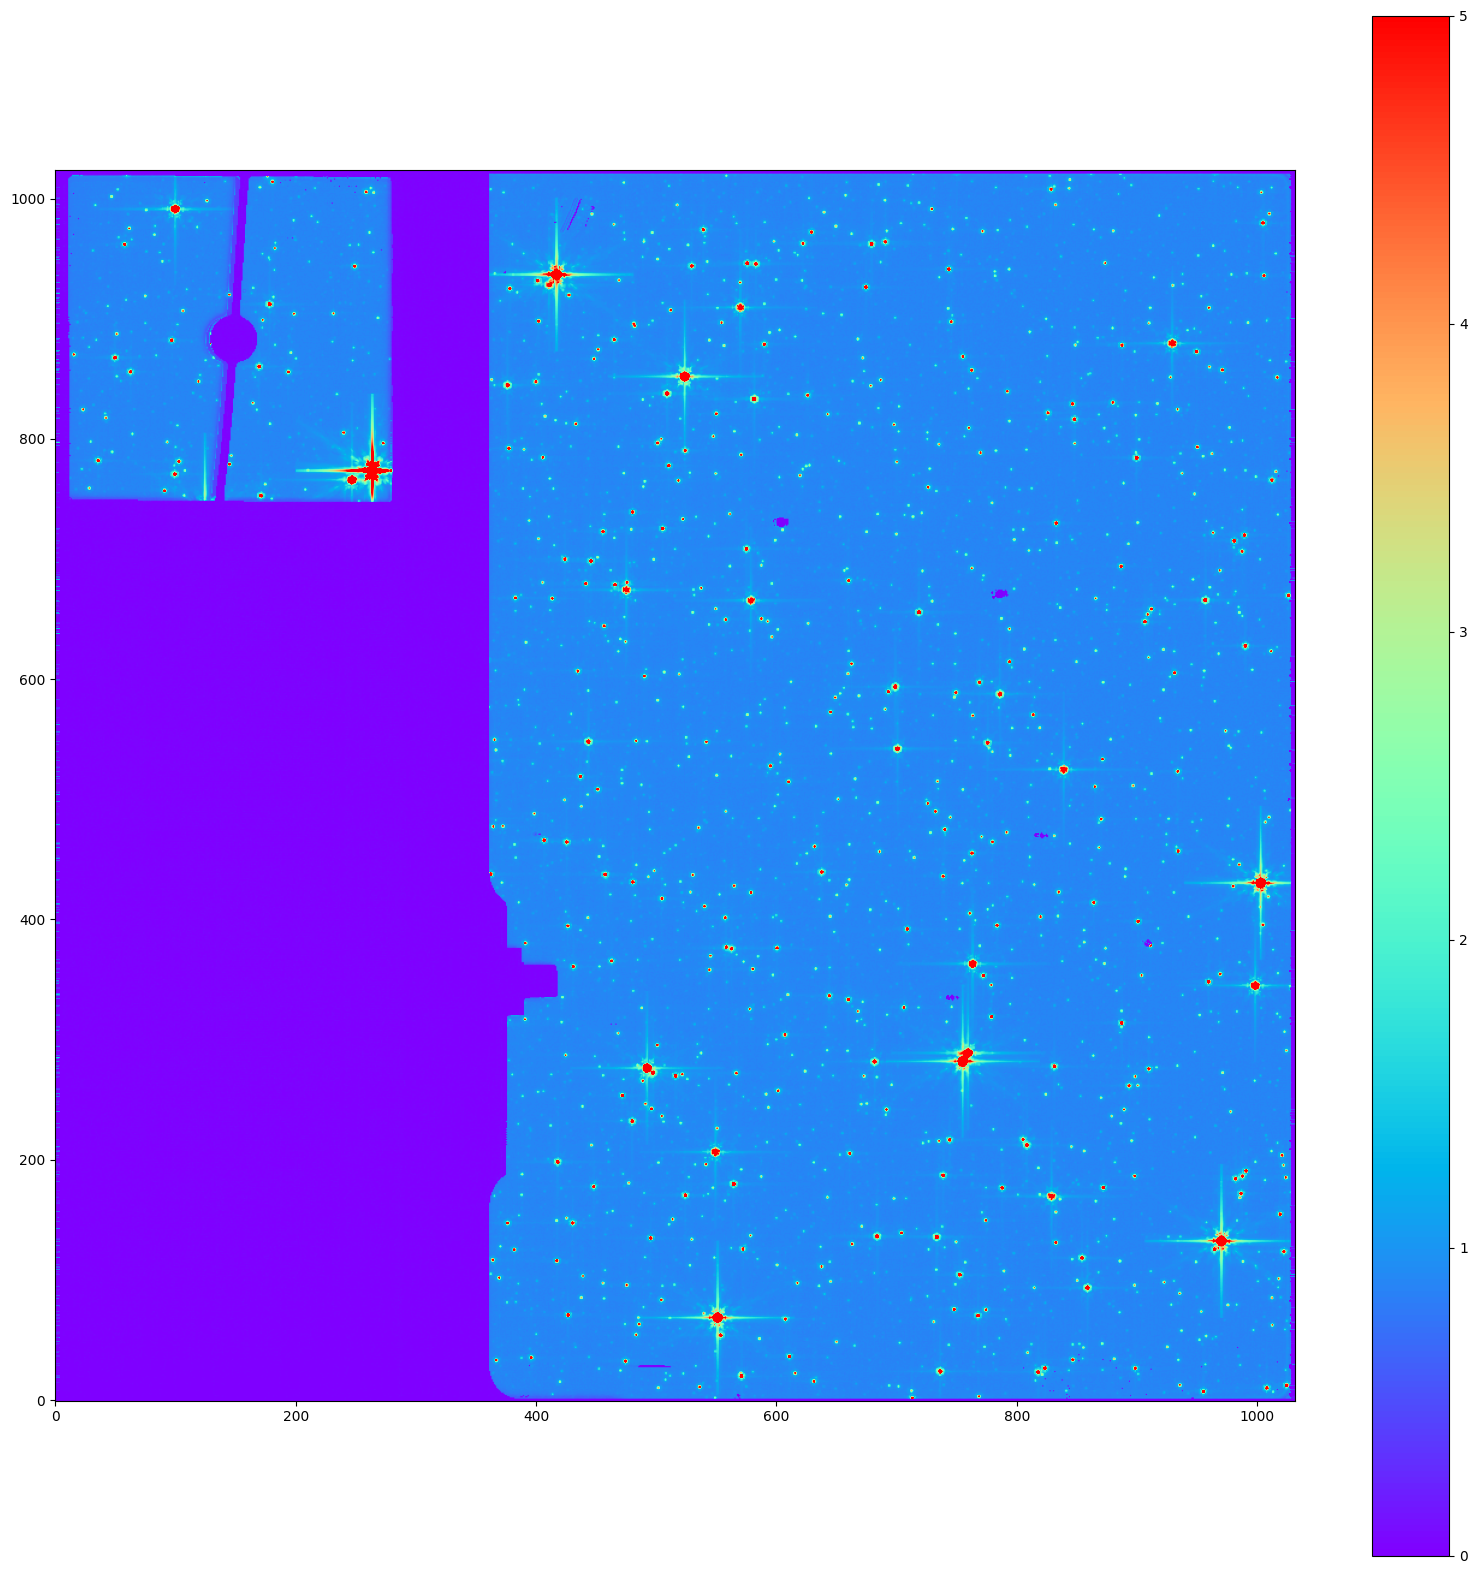

In [7]:
# Look at one image
im_file = ImageModel('det_image_seq1_MIRIMAGE_F560Wexp1_cal.fits')

# read in ecsv photom file
from astropy.visualization import LogStretch, PercentileInterval, ManualInterval

#viz2 = LogStretch() + ManualInterval(0,10)

plt.figure(figsize=(20,20))
#plt.imshow(viz2(im_file.data), origin='lower')
plt.imshow(im_file.data, origin='lower', cmap='rainbow', vmin=0, vmax=5)
plt.colorbar()

<a id="associations_ID"></a>
### Set up association files
The level three pipeline relies on an association file to specify which files are to be combined and provide the output file name.

[Top of Page](#title_ID)

In [8]:
# use asn_from_list to create association table
cal_list=imlist1
asn = asn_from_list.asn_from_list(cal_list, rule=DMS_Level3_Base, product_name='skymatch_combined.fits')

# use this if you need to add non'science' exposure types
#asn['products'][0]['members'][1]['exptype'] = 'background'
#asn['products'][0]['members'][2]['exptype'] = 'sourcecat'

# dump association table to a .json file for use in image3
with open('skymatch_asnfile.json', 'w') as fp:
    fp.write(asn.dump()[1])

skymatch_json_file='skymatch_asnfile.json'
    
json_file = skymatch_json_file
file_list = []
file_list2 = []
with open(json_file) as json_data:
    d = json.load(json_data)
    members = d['products'][0]['members']
    for item in np.arange(0,len(members)):
        file_list.append(members[item]['expname'])
        file_list2.append(members[item]['expname'][:-5]+"_skymatch.fits")

    
asn2 = asn_from_list.asn_from_list(file_list2, rule=DMS_Level3_Base, product_name=d['products'][0]['name'])

# use this if you need to add non'science' exposure types
#asn['products'][0]['members'][1]['exptype'] = 'background'
#asn['products'][0]['members'][2]['exptype'] = 'sourcecat'

# dump association table to a .json file for use in image3
with open('skymatch_asnfile2.json', 'w') as fp:
    fp.write(asn2.dump()[1])
    
skymatch_json_file2='skymatch_asnfile2.json'

### Modify average background level of input images

In [9]:
infile01_1 = input_files[0]
infile01_2 = input_files[1]
infile02_1 = input_files[2]
infile02_2 = input_files[3]

In [10]:
img01_1 = datamodels.open(infile01_1)
img01_2 = datamodels.open(infile01_2)
img02_1 = datamodels.open(infile02_1)
img02_2 = datamodels.open(infile02_2)

In [11]:
data01_1 = img01_1.data
data01_2 = img01_2.data
data02_1 = img02_1.data
data02_2 = img02_2.data

data01_1[data01_1<=0.3]=np.nan
data01_2[data01_2<=0.3]=np.nan
data02_1[data02_1<=0.3]=np.nan
data02_2[data02_2<=0.3]=np.nan

data01_1_orig = np.copy(img01_1.data)
data01_2_orig = np.copy(img01_2.data)
data02_1_orig = np.copy(img02_1.data)
data02_2_orig = np.copy(img02_2.data)

In [12]:
# check mean values of background 
print('Mean:', np.mean(data01_1_orig[data01_1_orig<=4.0]),' Standard deviation: ',np.std(data01_1_orig[data01_1_orig<=4.0]))
print('Mean:', np.mean(data01_2_orig[data01_2_orig<=4.0]),' Standard deviation: ',np.std(data01_2_orig[data01_2_orig<=4.0]))
print('Mean:', np.mean(data02_1_orig[data02_1_orig<=4.0]),' Standard deviation: ',np.std(data02_1_orig[data02_1_orig<=4.0]))
print('Mean:', np.mean(data02_2_orig[data02_2_orig<=4.0]),' Standard deviation: ',np.std(data02_2_orig[data02_2_orig<=4.0]))

Mean: 0.93090874  Standard deviation:  0.1817127
Mean: 0.9362799  Standard deviation:  0.17500266
Mean: 0.9330347  Standard deviation:  0.17194116
Mean: 0.93216574  Standard deviation:  0.16481434


In [13]:
# creating a background image with specified mean and gaussian noise with sigma = 1.0
bkg_img_noise_neg2 = np.random.normal(-2,2*0.2,data01_1.shape)
bkg_img_noise_2 = np.random.normal(2,2*0.2,data01_1.shape)
bkg_img_noise_3 = np.random.normal(3,3*0.2,data01_1.shape)
bkg_img_noise_4 = np.random.normal(4,4*0.2,data01_1.shape)
bkg_img_noise_5 = np.random.normal(5,5*0.2,data01_1.shape)
bkg_img_noise_7 = np.random.normal(7,7*0.2,data01_1.shape)

Replace the images with a noise image for easier background visualization

In [14]:
# adding the new background with specified mean and gaussian noise (above) to image (This overwrites, not adds.)
img01_1.data=bkg_img_noise_2
img01_2.data=bkg_img_noise_3
img02_1.data=bkg_img_noise_5
img02_2.data=bkg_img_noise_2

In [15]:
# checking the mean and standard deviations of the new background values
print('Mean:',np.nanmean(img01_1.data),' Standard deviation: ',np.nanstd(img01_1.data))
print('Mean:',np.nanmean(img01_2.data),' Standard deviation: ',np.nanstd(img01_2.data))
print('Mean:',np.nanmean(img02_1.data),' Standard deviation: ',np.nanstd(img02_1.data))
print('Mean:',np.nanmean(img02_2.data),' Standard deviation: ',np.nanstd(img02_2.data))

Mean: 2.0005329  Standard deviation:  0.39937514
Mean: 3.0002089  Standard deviation:  0.59970844
Mean: 5.0004926  Standard deviation:  1.0004022
Mean: 2.0005329  Standard deviation:  0.39937514


In [16]:
img01_1.save(file_list2[0],overwrite=True)
img01_2.save(file_list2[1],overwrite=True)
img02_1.save(file_list2[2],overwrite=True)
img02_2.save(file_list2[3],overwrite=True)

'det_image_seq4_MIRIMAGE_F560Wexp1_cal_skymatch.fits'

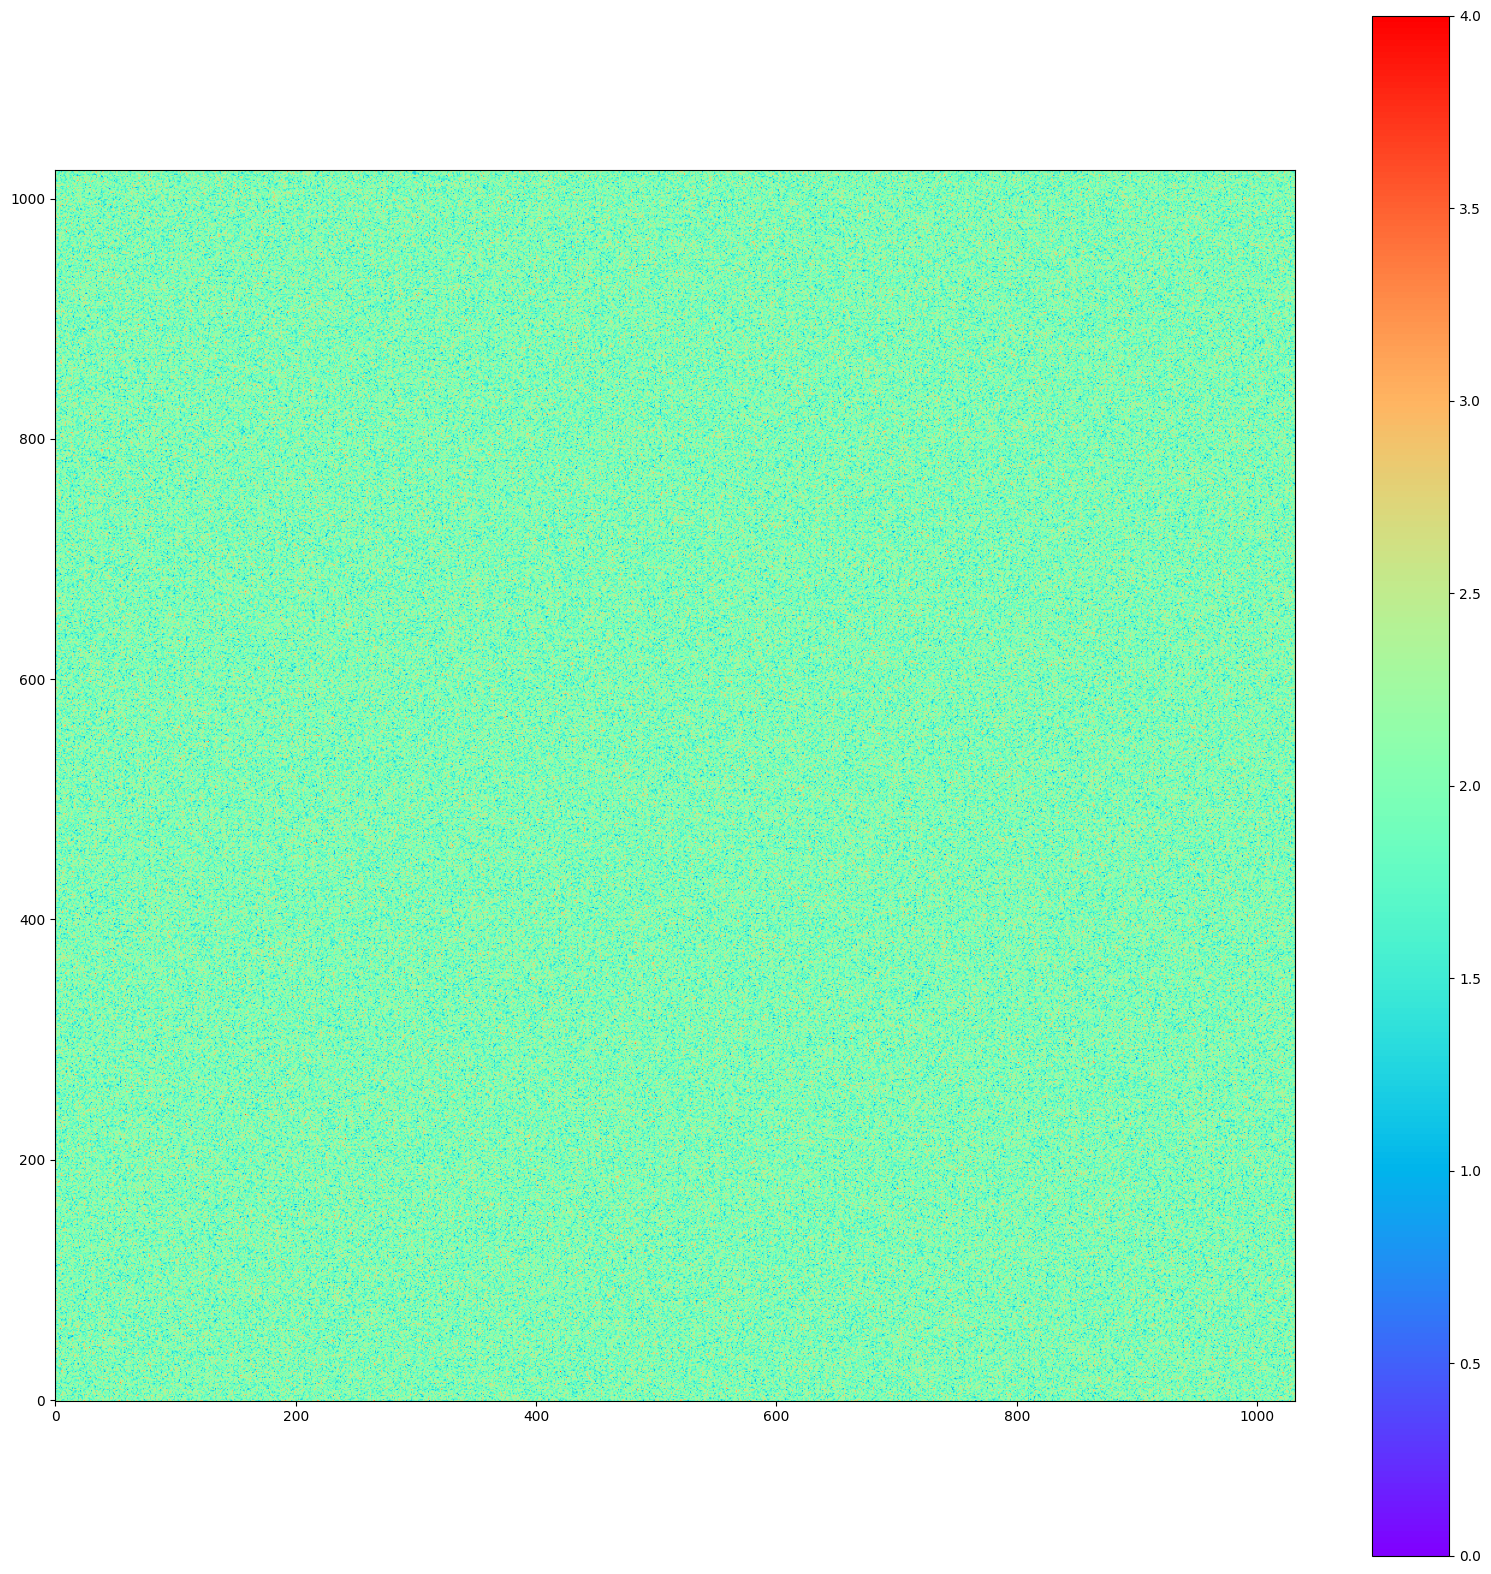

In [17]:
# Look at one image
im_file = ImageModel(file_list2[0])

# read in ecsv photom file
from astropy.visualization import LogStretch, PercentileInterval, ManualInterval

#viz2 = LogStretch() + ManualInterval(0,10)

plt.figure(figsize=(20,20))
#plt.imshow(viz2(im_file.data), origin='lower')
plt.imshow(im_file.data, origin='lower', cmap='rainbow', vmin=0, vmax=4)
plt.colorbar()

<a id="pipeline_ID"></a>
## Run Pipeline steps

Run the pipeline on the data for different sets of parameters

## 1. Run skymatch step on images with skymatch method = 'local'

Notes: ‘local’: compute sky background values of each input image or group of images (members of the same “exposure”). A single sky value is computed for each group of images. This method simply computes the mean/median/mode/etc. value of the “sky” separately in each input image. This will resulted in subtracted background being near zero in the combined image, as each image has it's individual background subtracted.

match_down specifies whether the sky differences should be subtracted from images with higher sky values (match_down = True) in order to match the image with the lowest sky or sky differences should be added to the images with lower sky values to match the sky of the image with the highest sky value (match_down = False). (Default = True)

'Subtract' specifies whether the computed sky background values are to be subtracted from the images in the skymatch step. (Default = False) Currently, if not done in skymatch, the subtraction is performed in resample. 

### 1.1 Run skymatch with sky match method = local. Subtract = False, match_down = True.


In [18]:
# skymatch, local, subtract= False, all 4 images used
#jwst.skymatch.skymatch_step.SkyMatchStep.call(skymatch_json_file2, skymethod='local', subtract=False,output_file='MIRI',save_results=True)

In [19]:
# Test running just skymatch and resample and skiping other steps.

# Run Calwebb_image3 on the association table
    
# set any specific parameters
skymethod = 'local' # sky computation algorithm to be used. Allowed values: {local, global, match, global+match} (Default = global+match
match_down = True # Specifies whether the sky differences should be subtracted from images with higher sky values (match_down = True) in order to match the image with the lowest sky or sky differences should be added to the images with lower sky values to match the sky of the image with the highest sky value (match_down = False). (Default = True
subtract = False # Specifies whether the computed sky background values are to be subtracted from the images. (Default = False   
    
pipe3=Image3Pipeline()    
pipe3.tweakreg.skip = True
pipe3.outlier_detection.skip = True
pipe3.source_catalog.skip = True

pipe3.skymatch.skymethod = skymethod
pipe3.skymatch.match_down = match_down
pipe3.skymatch.subtract = subtract
pipe3.skymatch.output_file = 'MIRI'
pipe3.skymatch.save_results = True

pipe3.resample.save_results = True

pipe3.save_results = True

# run Image3

image = pipe3.run(skymatch_json_file2)
print('Image 3 pipeline finished.')

2022-09-19 21:00:15,043 - stpipe.Image3Pipeline - INFO - Image3Pipeline instance created.


2022-09-19 21:00:15,045 - stpipe.Image3Pipeline.assign_mtwcs - INFO - AssignMTWcsStep instance created.


2022-09-19 21:00:15,048 - stpipe.Image3Pipeline.tweakreg - INFO - TweakRegStep instance created.


2022-09-19 21:00:15,050 - stpipe.Image3Pipeline.skymatch - INFO - SkyMatchStep instance created.


2022-09-19 21:00:15,052 - stpipe.Image3Pipeline.outlier_detection - INFO - OutlierDetectionStep instance created.


2022-09-19 21:00:15,054 - stpipe.Image3Pipeline.resample - INFO - ResampleStep instance created.


2022-09-19 21:00:15,056 - stpipe.Image3Pipeline.source_catalog - INFO - SourceCatalogStep instance created.


2022-09-19 21:00:15,226 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline running with args ('skymatch_asnfile2.json',).


2022-09-19 21:00:15,236 - stpipe.Image3Pipeline - INFO - Step Image3Pipeline parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'steps': {'assign_mtwcs': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': False, 'suffix': 'assign_mtwcs', 'search_output_file': True, 'input_dir': ''}, 'tweakreg': {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_catalogs': False, 'catalog_format': 'ecsv', 'kernel_fwhm': 2.5, 'snr_threshold': 10.0, 'sharplo': 0.

2022-09-19 21:00:15,413 - stpipe.Image3Pipeline - INFO - Prefetching reference files for dataset: 'det_image_seq1_MIRIMAGE_F560Wexp1_cal_skymatch.fits' reftypes = ['drizpars']


2022-09-19 21:00:17,263 - CRDS - INFO -  Fetching  /tmp/crds_cache/references/jwst/miri/jwst_miri_drizpars_0001.fits    8.6 K bytes  (1 / 1 files) (0 / 8.6 K bytes)


2022-09-19 21:00:17,265 - CRDS - ERROR -  Failure downloading file 'jwst_miri_drizpars_0001.fits' : Error fetching data for 'jwst_miri_drizpars_0001.fits' at CRDS server 'https://jwst-crds.stsci.edu' with mode 'http' : [Errno 28] No space left on device: '/tmp/crds_cache/references/jwst/miri/jwst_miri_drizpars_0001.fits'


2022-09-19 21:00:17,266 - stpipe.Image3Pipeline - INFO - Prefetch for DRIZPARS reference file is '/tmp/crds_cache/references/jwst/miri/jwst_miri_drizpars_0001.fits'.


2022-09-19 21:00:17,266 - stpipe.Image3Pipeline - INFO - First argument skymatch_asnfile2.json does not appear to be a model


2022-09-19 21:00:17,267 - stpipe.Image3Pipeline - INFO - Starting calwebb_image3 ...


2022-09-19 21:00:17,909 - stpipe.Image3Pipeline.tweakreg - INFO - Step tweakreg running with args (<ModelContainer>,).


2022-09-19 21:00:17,911 - stpipe.Image3Pipeline.tweakreg - INFO - Step tweakreg parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': True, 'output_use_index': True, 'save_results': False, 'skip': True, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'save_catalogs': False, 'catalog_format': 'ecsv', 'kernel_fwhm': 2.5, 'snr_threshold': 10.0, 'sharplo': 0.2, 'sharphi': 1.0, 'roundlo': -1.0, 'roundhi': 1.0, 'brightest': 200, 'peakmax': None, 'bkg_boxsize': 400, 'enforce_user_order': False, 'expand_refcat': False, 'minobj': 15, 'searchrad': 2.0, 'use2dhist': True, 'separation': 1.0, 'tolerance': 0.7, 'xoffset': 0.0, 'yoffset': 0.0, 'fitgeometry': 'rshift', 'nclip': 3, 'sigma': 3.0, 'abs_refcat': '', 'save_abs_catalog': False, 'abs_minobj': 15, 'abs_searchrad': 6.0, 'abs_use2dhist': True, 'abs_separation': 0.1, 'abs_tolerance': 0.7, 'abs_fitgeometry': 'rshift', 'abs_nclip': 3, 'abs_sigma': 3.0}


2022-09-19 21:00:17,911 - stpipe.Image3Pipeline.tweakreg - INFO - Step skipped.


2022-09-19 21:00:17,920 - stpipe.Image3Pipeline.tweakreg - INFO - Step tweakreg done


2022-09-19 21:00:18,046 - stpipe.Image3Pipeline.skymatch - INFO - Step skymatch running with args (<ModelContainer>,).


2022-09-19 21:00:18,048 - stpipe.Image3Pipeline.skymatch - INFO - Step skymatch parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': '/internal/data1/jenkins/workspace/Notebooks/jwst_validation_notebooks_spacetelescope/tmp/tmppwhxh0sf/MIRI', 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': None, 'search_output_file': True, 'input_dir': '', 'skymethod': 'local', 'match_down': True, 'subtract': False, 'stepsize': None, 'skystat': 'mode', 'dqbits': '~DO_NOT_USE+NON_SCIENCE', 'lower': None, 'upper': None, 'nclip': 5, 'lsigma': 4.0, 'usigma': 4.0, 'binwidth': 0.1}


2022-09-19 21:00:18,173 - stpipe.Image3Pipeline.skymatch - INFO -  


2022-09-19 21:00:18,174 - stpipe.Image3Pipeline.skymatch - INFO - ***** jwst.skymatch.skymatch.match() started on 2022-09-19 21:00:18.173907


2022-09-19 21:00:18,175 - stpipe.Image3Pipeline.skymatch - INFO -  


2022-09-19 21:00:18,175 - stpipe.Image3Pipeline.skymatch - INFO - Sky computation method: 'local'


2022-09-19 21:00:18,175 - stpipe.Image3Pipeline.skymatch - INFO - Sky subtraction from image data: OFF


2022-09-19 21:00:18,176 - stpipe.Image3Pipeline.skymatch - INFO -  


2022-09-19 21:00:18,177 - stpipe.Image3Pipeline.skymatch - INFO - ----  Sky values computed per image and/or image groups.


2022-09-19 21:00:18,255 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=det_image_seq1_MIRIMAGE_F560Wexp1_cal_skymatch.fits. Sky background: 1.95766


2022-09-19 21:00:18,256 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=det_image_seq2_MIRIMAGE_F560Wexp1_cal_skymatch.fits. Sky background: 3.0267


2022-09-19 21:00:18,256 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=det_image_seq3_MIRIMAGE_F560Wexp1_cal_skymatch.fits. Sky background: 4.99961


2022-09-19 21:00:18,257 - stpipe.Image3Pipeline.skymatch - INFO -    *  Image ID=det_image_seq4_MIRIMAGE_F560Wexp1_cal_skymatch.fits. Sky background: 1.95766


2022-09-19 21:00:18,257 - stpipe.Image3Pipeline.skymatch - INFO -  


2022-09-19 21:00:18,258 - stpipe.Image3Pipeline.skymatch - INFO - ***** jwst.skymatch.skymatch.match() ended on 2022-09-19 21:00:18.257645


2022-09-19 21:00:18,258 - stpipe.Image3Pipeline.skymatch - INFO - ***** jwst.skymatch.skymatch.match() TOTAL RUN TIME: 0:00:00.083738


2022-09-19 21:00:18,259 - stpipe.Image3Pipeline.skymatch - INFO -  


2022-09-19 21:00:18,544 - stpipe.Image3Pipeline.skymatch - INFO - Saved model in MIRI_0_skymatch.fits


2022-09-19 21:00:18,810 - stpipe.Image3Pipeline.skymatch - INFO - Saved model in MIRI_1_skymatch.fits


2022-09-19 21:00:19,107 - stpipe.Image3Pipeline.skymatch - INFO - Saved model in MIRI_2_skymatch.fits


2022-09-19 21:00:19,368 - stpipe.Image3Pipeline.skymatch - INFO - Saved model in MIRI_3_skymatch.fits


2022-09-19 21:00:19,369 - stpipe.Image3Pipeline.skymatch - INFO - Step skymatch done


2022-09-19 21:00:19,537 - stpipe.Image3Pipeline.outlier_detection - INFO - Step outlier_detection running with args (<ModelContainer>,).


2022-09-19 21:00:19,539 - stpipe.Image3Pipeline.outlier_detection - INFO - Step outlier_detection parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': True, 'suffix': 'crf', 'search_output_file': False, 'input_dir': '', 'weight_type': 'ivm', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'nlow': 0, 'nhigh': 0, 'maskpt': 0.7, 'grow': 1, 'snr': '5.0 4.0', 'scale': '1.2 0.7', 'backg': 0.0, 'save_intermediate_results': False, 'resample_data': True, 'good_bits': '~DO_NOT_USE', 'scale_detection': False, 'allowed_memory': None, 'in_memory': False}


2022-09-19 21:00:19,540 - stpipe.Image3Pipeline.outlier_detection - INFO - Step skipped.


2022-09-19 21:00:19,550 - stpipe.Image3Pipeline.outlier_detection - INFO - Step outlier_detection done


2022-09-19 21:00:19,694 - stpipe.Image3Pipeline.resample - INFO - Step resample running with args (<ModelContainer>,).


2022-09-19 21:00:19,695 - stpipe.Image3Pipeline.resample - INFO - Step resample parameters are: {'pre_hooks': [], 'post_hooks': [], 'output_file': None, 'output_dir': None, 'output_ext': '.fits', 'output_use_model': False, 'output_use_index': True, 'save_results': True, 'skip': False, 'suffix': 'i2d', 'search_output_file': True, 'input_dir': '', 'pixfrac': 1.0, 'kernel': 'square', 'fillval': 'INDEF', 'weight_type': 'ivm', 'output_shape': None, 'crpix': None, 'crval': None, 'rotation': None, 'pixel_scale_ratio': 1.0, 'pixel_scale': None, 'single': False, 'blendheaders': True, 'allowed_memory': None, 'in_memory': True}


2022-09-19 21:00:19,710 - CRDS - INFO -  Fetching  /tmp/crds_cache/references/jwst/miri/jwst_miri_drizpars_0001.fits    8.6 K bytes  (1 / 1 files) (0 / 8.6 K bytes)


2022-09-19 21:00:19,712 - CRDS - ERROR -  Failure downloading file 'jwst_miri_drizpars_0001.fits' : Error fetching data for 'jwst_miri_drizpars_0001.fits' at CRDS server 'https://jwst-crds.stsci.edu' with mode 'http' : [Errno 28] No space left on device: '/tmp/crds_cache/references/jwst/miri/jwst_miri_drizpars_0001.fits'


FileNotFoundError: [Errno 2] No such file or directory: '/tmp/crds_cache/references/jwst/miri/jwst_miri_drizpars_0001.fits'

In [ ]:
# Check values out of skymatch step. With subtract = False, values should be equal.

img01_1_new = datamodels.open('MIRI_0_skymatch.fits')
img01_2_new = datamodels.open('MIRI_1_skymatch.fits')
img02_1_new = datamodels.open('MIRI_2_skymatch.fits')
img02_2_new = datamodels.open('MIRI_3_skymatch.fits')

print('Original and new levels should be equal. If subtract=False, skymatch should not subtract.')
print('Mean: original, new (local)')
print('Mean:',np.mean(img01_1.data),',', np.mean(img01_1_new.data))
print('Mean:',np.mean(img01_2.data),',', np.mean(img01_2_new.data))
print('Mean:',np.mean(img02_1.data),',', np.mean(img02_1_new.data))
print('Mean:',np.mean(img02_2.data),',', np.mean(img02_2_new.data))

In [ ]:
# Look at combined image
im_file = ImageModel('skymatch_combined_i2d.fits')

print('The resample step should subtract the individual backgrounds found in the skymatch step.')
print('Since the local individual background level is subtracted from each image, final expected result is near zero.')
print('Mean:',np.mean(im_file.data[600:700,600:700]))

# read in ecsv photom file
from astropy.visualization import LogStretch, PercentileInterval, ManualInterval

#viz2 = LogStretch() + ManualInterval(0,10)

plt.figure(figsize=(20,20))
#plt.imshow(viz2(im_file.data), origin='lower')
plt.imshow(im_file.data, origin='lower', cmap='rainbow', vmin=0, vmax=4)
plt.colorbar()

### 1.2  Skymatch method = 'Local', subtract= True. 

Skymatch step should subtract the background. Resample background level should match the skymatch background level since subtraction has already been done

In [ ]:
# skymatch, local, subtract = True, all 4 images used
#jwst.skymatch.skymatch_step.SkyMatchStep.call(skymatch_json_file2, skymethod='local', subtract=True,output_file='MIRI',save_results=True)

In [ ]:
# Test running just skymatch and resample and skiping other steps.

# Run Calwebb_image3 on the association table
    
# set any specific parameters
skymethod = 'local' # sky computation algorithm to be used. Allowed values: {local, global, match, global+match} (Default = global+match
#match_down = True # Specifies whether the sky differences should be subtracted from images with higher sky values (match_down = True) in order to match the image with the lowest sky or sky differences should be added to the images with lower sky values to match the sky of the image with the highest sky value (match_down = False). (Default = True
subtract = True # Specifies whether the computed sky background values are to be subtracted from the images. (Default = False   
    
pipe3=Image3Pipeline()    
pipe3.tweakreg.skip = True
pipe3.outlier_detection.skip = True
pipe3.source_catalog.skip = True

pipe3.skymatch.skymethod = skymethod
#pipe3.skymatch.match_down = match_down
pipe3.skymatch.subtract = subtract
pipe3.skymatch.output_file = 'MIRI'
pipe3.skymatch.save_results = True

pipe3.resample.save_results = True

pipe3.save_results = True

# run Image3

image = pipe3.run(skymatch_json_file2)
print('Image 3 pipeline finished.')

In [ ]:
img01_1_new = datamodels.open('MIRI_0_skymatch.fits')
img01_2_new = datamodels.open('MIRI_1_skymatch.fits')
img02_1_new = datamodels.open('MIRI_2_skymatch.fits')
img02_2_new = datamodels.open('MIRI_3_skymatch.fits')

print('With subtract=True, the new value should show that the background value was subtracted.')
print('Mean: original, new (local)')
print('Mean:',np.mean(img01_1.data),',', np.mean(img01_1_new.data))
print('Mean:',np.mean(img01_2.data),',', np.mean(img01_2_new.data))
print('Mean:',np.mean(img02_1.data),',', np.mean(img02_1_new.data))
print('Mean:',np.mean(img02_2.data),',', np.mean(img02_2_new.data))

In [ ]:
# Look at combined image
im_file = ImageModel('skymatch_combined_i2d.fits')

print('The background value was subtracted in the skymatch step, no additional subtraction should be done here.')
print('This value should match the values in the new column above.')
print('Mean:',np.mean(im_file.data[600:700,600:700]))

# read in ecsv photom file
from astropy.visualization import LogStretch, PercentileInterval, ManualInterval

#viz2 = LogStretch() + ManualInterval(0,10)

plt.figure(figsize=(20,20))
#plt.imshow(viz2(im_file.data), origin='lower')
plt.imshow(im_file.data, origin='lower', cmap='rainbow', vmin=0, vmax=4)
plt.colorbar()

## 2. Run skymatch for skymethod = 'global'.


##### Notes: ‘global’: compute a common sky value for all input image and groups of images. In this setting match will compute sky values for each input image/group, find the minimum sky value, and then it will set (and/or subtract) sky value of each input image to this minimum value. This method may be useful when input images have been already matched. The 'global' method computes the minimum sky value across all input images and/or groups. That sky value is then considered to be the background in all input images.

This calculates an average sky across all images and subtracts that average from all images. There should be a warning for users for this step that makes it clear that this should not be used on images with differences in background levels.

### 2.1 skymethod = 'global' with subtraction = False

In [ ]:
# skymatch, local
#jwst.skymatch.skymatch_step.SkyMatchStep.call(skymatch_json_file2, skymethod='local', subtract=False,output_file='MIRI',save_results=True)

In [ ]:
# Test running just skymatch and resample and skiping other steps.

# Run Calwebb_image3 on the association table
    
# set any specific parameters
skymethod = 'global' # sky computation algorithm to be used. Allowed values: {local, global, match, global+match} (Default = global+match
#match_down = True # Specifies whether the sky differences should be subtracted from images with higher sky values (match_down = True) in order to match the image with the lowest sky or sky differences should be added to the images with lower sky values to match the sky of the image with the highest sky value (match_down = False). (Default = True
subtract = False # Specifies whether the computed sky background values are to be subtracted from the images. (Default = False   
    
pipe3=Image3Pipeline()    
pipe3.tweakreg.skip = True
pipe3.outlier_detection.skip = True
pipe3.source_catalog.skip = True

pipe3.skymatch.skymethod = skymethod
#pipe3.skymatch.match_down = match_down
pipe3.skymatch.subtract = subtract
pipe3.skymatch.output_file = 'MIRI'
pipe3.skymatch.save_results = True

pipe3.resample.save_results = True

pipe3.save_results = True

# run Image3

image = pipe3.run(skymatch_json_file2)
print('Image 3 pipeline finished.')

In [ ]:
img01_1_new = datamodels.open('MIRI_0_skymatch.fits')
img01_2_new = datamodels.open('MIRI_1_skymatch.fits')
img02_1_new = datamodels.open('MIRI_2_skymatch.fits')
img02_2_new = datamodels.open('MIRI_3_skymatch.fits')

print('There should be no subtraction at this step, with subtraction = False.')
print('Mean: original, new (local)')
print('Mean:',np.mean(img01_1.data),',', np.mean(img01_1_new.data))
print('Mean:',np.mean(img01_2.data),',', np.mean(img01_2_new.data))
print('Mean:',np.mean(img02_1.data),',', np.mean(img02_1_new.data))
print('Mean:',np.mean(img02_2.data),',', np.mean(img02_2_new.data))

In [ ]:
# Look at combined image
im_file = ImageModel('skymatch_combined_i2d.fits')

print('Global finds a single value for the background, and subtracts that value from all images.')
print('The value listed here should be the average of the subtracted sky values across images.')
print('The combined image will look messy as the same value was subtracted from the image with background = 5')
print('and from the images with background = 2. This shows the differing backgrounds strongly.')
print('Mean:',np.mean(im_file.data[600:700,600:700]))

# read in ecsv photom file
from astropy.visualization import LogStretch, PercentileInterval, ManualInterval

#viz2 = LogStretch() + ManualInterval(0,10)

plt.figure(figsize=(20,20))
#plt.imshow(viz2(im_file.data), origin='lower')
plt.imshow(im_file.data, origin='lower', cmap='rainbow', vmin=0, vmax=4)
plt.colorbar()

### 2.2 skymethod = 'global' with subtraction = True

In [ ]:
# skymatch, global, subtract = True
#jwst.skymatch.skymatch_step.SkyMatchStep.call(skymatch_json_file2, skymethod='global', subtract=True,output_file='MIRI',save_results=True)

In [ ]:
# Test running just skymatch and resample and skiping other steps.

# Run Calwebb_image3 on the association table
    
# set any specific parameters
skymethod = 'global' # sky computation algorithm to be used. Allowed values: {local, global, match, global+match} (Default = global+match
#match_down = True # Specifies whether the sky differences should be subtracted from images with higher sky values (match_down = True) in order to match the image with the lowest sky or sky differences should be added to the images with lower sky values to match the sky of the image with the highest sky value (match_down = False). (Default = True
subtract = True # Specifies whether the computed sky background values are to be subtracted from the images. (Default = False   
    
pipe3=Image3Pipeline()    
pipe3.tweakreg.skip = True
pipe3.outlier_detection.skip = True
pipe3.source_catalog.skip = True

pipe3.skymatch.skymethod = skymethod
#pipe3.skymatch.match_down = match_down
pipe3.skymatch.subtract = subtract
pipe3.skymatch.output_file = 'MIRI'
pipe3.skymatch.save_results = True

pipe3.resample.save_results = True

pipe3.save_results = True

# run Image3

image = pipe3.run(skymatch_json_file2)
print('Image 3 pipeline finished.')

In [ ]:
img01_1_new = datamodels.open('MIRI_0_skymatch.fits')
img01_2_new = datamodels.open('MIRI_1_skymatch.fits')
img02_1_new = datamodels.open('MIRI_2_skymatch.fits')
img02_2_new = datamodels.open('MIRI_3_skymatch.fits')

print('Global finds a single value for the background, and subtracts that value from all images.')
print('The values listed here should be the average of the subtracted sky values across images subtracted from each image.')
print('Mean: original, new (global)')
print('Mean:',np.mean(img01_1.data),',', np.mean(img01_1_new.data))
print('Mean:',np.mean(img01_2.data),',', np.mean(img01_2_new.data))
print('Mean:',np.mean(img02_1.data),',', np.mean(img02_1_new.data))
print('Mean:',np.mean(img02_2.data),',', np.mean(img02_2_new.data))

In [ ]:
# Look at combined image
im_file = ImageModel('skymatch_combined_i2d.fits')

print('Global finds a single value for the background, and subtracts that value from all images.')
print('The value listed here should be the average of the subtracted sky values across images.')
print('The combined image will look messy as the same value was subtracted from the image with background = 5')
print('and from the images with background = 2. This shows the differing backgrounds strongly.')
print('Mean:',np.mean(im_file.data[600:700,600:700]))

# read in ecsv photom file
from astropy.visualization import LogStretch, PercentileInterval, ManualInterval

#viz2 = LogStretch() + ManualInterval(0,10)

plt.figure(figsize=(20,20))
#plt.imshow(viz2(im_file.data), origin='lower')
plt.imshow(im_file.data, origin='lower', cmap='rainbow', vmin=0, vmax=4)
plt.colorbar()

## 3. Run tests on Skymatch method 'Match'
##### Notes: ‘match’: compute differences in sky values between images and/or groups in (pair-wise) common sky regions. In this case computed sky values will be relative (delta) to the sky computed in one of the input images whose sky value will be set to (reported to be) 0. This case matches to the lowest sky value.

Based on whether match_down is set to True or False, Match will calculate the difference between the lowest background level or highest level (respectively), and subtract the difference between the calculated level and the 'matched' level.

This is the preferred default option as it subtracts the differences between the background levels, normalizing all of the backgrounds to a common level (either lowest or highest background), rather than subtracting off all of the background.

### 3.1 skymethod = 'match', match_down=True, subtract=True

In [ ]:
# skymatch, match down, subtract = True
#jwst.skymatch.skymatch_step.SkyMatchStep.call(skymatch_json_file2, skymethod='match', match_down=True,subtract=True,output_file='MIRI',save_results=True)

In [ ]:
# Test running just skymatch and resample and skiping other steps.

# Run Calwebb_image3 on the association table
    
# set any specific parameters
skymethod = 'match' # sky computation algorithm to be used. Allowed values: {local, global, match, global+match} (Default = global+match
match_down = True # Specifies whether the sky differences should be subtracted from images with higher sky values (match_down = True) in order to match the image with the lowest sky or sky differences should be added to the images with lower sky values to match the sky of the image with the highest sky value (match_down = False). (Default = True
subtract = True # Specifies whether the computed sky background values are to be subtracted from the images. (Default = False   
    
pipe3=Image3Pipeline()    
pipe3.tweakreg.skip = True
pipe3.outlier_detection.skip = True
pipe3.source_catalog.skip = True

pipe3.skymatch.skymethod = skymethod
pipe3.skymatch.match_down = match_down
pipe3.skymatch.subtract = subtract
pipe3.skymatch.output_file = 'MIRI'
pipe3.skymatch.save_results = True

pipe3.resample.save_results = True

pipe3.save_results = True

# run Image3

image = pipe3.run(skymatch_json_file2)
print('Image 3 pipeline finished.')

In [ ]:
img01_1_new = datamodels.open('MIRI_0_skymatch.fits')
img01_2_new = datamodels.open('MIRI_1_skymatch.fits')
img02_1_new = datamodels.open('MIRI_2_skymatch.fits')
img02_2_new = datamodels.open('MIRI_3_skymatch.fits')

print('There should be no subtraction at this step, with subtraction = False.')
print('Mean: original, new (match down)')
print('Mean:',np.mean(img01_1.data),',', np.mean(img01_1_new.data))
print('Mean:',np.mean(img01_2.data),',', np.mean(img01_2_new.data))
print('Mean:',np.mean(img02_1.data),',', np.mean(img02_1_new.data))
print('Mean:',np.mean(img02_2.data),',', np.mean(img02_2_new.data))

In [ ]:
# Look at combined image
im_file = ImageModel('skymatch_combined_i2d.fits')

print('For the method match with match_down= True, the value of the background should match the minimum of the individual backgrounds.')
print('This value should match the values in the new column above. Subtraction was done in skymatch step.')
print('Mean:',np.mean(im_file.data[600:700,600:700]))

# read in ecsv photom file
from astropy.visualization import LogStretch, PercentileInterval, ManualInterval

#viz2 = LogStretch() + ManualInterval(0,10)

plt.figure(figsize=(20,20))
#plt.imshow(viz2(im_file.data), origin='lower')
plt.imshow(im_file.data, origin='lower', cmap='rainbow', vmin=0, vmax=4)
plt.colorbar()

### ** Check that all output (new) sky values are equal to the lowest original sky value 

### 3.2 skymethod = 'match', match_down=False, subtract = True

In [ ]:
# skymatch, match up, subtract = True
#jwst.skymatch.skymatch_step.SkyMatchStep.call(skymatch_json_file2, skymethod='match', match_down=False,subtract=True,output_file='MIRI',save_results=True)

In [ ]:
# Test running just skymatch and resample and skiping other steps.

# Run Calwebb_image3 on the association table
    
# set any specific parameters
skymethod = 'match' # sky computation algorithm to be used. Allowed values: {local, global, match, global+match} (Default = global+match
match_down = False # Specifies whether the sky differences should be subtracted from images with higher sky values (match_down = True) in order to match the image with the lowest sky or sky differences should be added to the images with lower sky values to match the sky of the image with the highest sky value (match_down = False). (Default = True
subtract = True # Specifies whether the computed sky background values are to be subtracted from the images. (Default = False   
    
pipe3=Image3Pipeline()    
pipe3.tweakreg.skip = True
pipe3.outlier_detection.skip = True
pipe3.source_catalog.skip = True

pipe3.skymatch.skymethod = skymethod
pipe3.skymatch.match_down = match_down
pipe3.skymatch.subtract = subtract
pipe3.skymatch.output_file = 'MIRI'
pipe3.skymatch.save_results = True

pipe3.resample.save_results = True

pipe3.save_results = True

# run Image3

image = pipe3.run(skymatch_json_file2)
print('Image 3 pipeline finished.')

In [ ]:
img01_1_new = datamodels.open('MIRI_0_skymatch.fits')
img01_2_new = datamodels.open('MIRI_1_skymatch.fits')
img02_1_new = datamodels.open('MIRI_2_skymatch.fits')
img02_2_new = datamodels.open('MIRI_3_skymatch.fits')

print('With match_down = False, match will match the backgrounds of all to the highest background.')
print('With subtract = True, the background matching is done at the skymatch step.')
print('Mean: original, new (match up)')
print('Mean:',np.mean(img01_1.data),',', np.mean(img01_1_new.data))
print('Mean:',np.mean(img01_2.data),',', np.mean(img01_2_new.data))
print('Mean:',np.mean(img02_1.data),',', np.mean(img02_1_new.data))
print('Mean:',np.mean(img02_2.data),',', np.mean(img02_2_new.data))

In [ ]:
# Look at combined image
im_file = ImageModel('skymatch_combined_i2d.fits')

print('For the method match with match_down=False, the value of the background should match the maximum of the individual backgrounds')
print('This value should match the values in the new column above. Subtraction was done in skymatch step.')
print('Mean:',np.mean(im_file.data[600:700,600:700]))

# read in ecsv photom file
from astropy.visualization import LogStretch, PercentileInterval, ManualInterval

#viz2 = LogStretch() + ManualInterval(0,10)

plt.figure(figsize=(20,20))
#plt.imshow(viz2(im_file.data), origin='lower')
plt.imshow(im_file.data, origin='lower', cmap='rainbow', vmin=0, vmax=4)
plt.colorbar()

### ** Check that all output (new) sky values are equal to the highest original sky value 

### 3.3 skymethod = 'match', match_down = True, subtract = False

In [ ]:
# Test running just skymatch and resample and skiping other steps.

# Run Calwebb_image3 on the association table
    
# set any specific parameters
skymethod = 'match' # sky computation algorithm to be used. Allowed values: {local, global, match, global+match} (Default = global+match
match_down = True # Specifies whether the sky differences should be subtracted from images with higher sky values (match_down = True) in order to match the image with the lowest sky or sky differences should be added to the images with lower sky values to match the sky of the image with the highest sky value (match_down = False). (Default = True
subtract = False # Specifies whether the computed sky background values are to be subtracted from the images. (Default = False   
    
pipe3=Image3Pipeline()    
pipe3.tweakreg.skip = True
pipe3.outlier_detection.skip = True
pipe3.source_catalog.skip = True

pipe3.skymatch.skymethod = skymethod
pipe3.skymatch.match_down = match_down
pipe3.skymatch.subtract = subtract
pipe3.skymatch.output_file = 'MIRI'
pipe3.skymatch.save_results = True

pipe3.resample.save_results = True

pipe3.save_results = True

# run Image3

image = pipe3.run(skymatch_json_file2)
print('Image 3 pipeline finished.')

In [ ]:
img01_1_new = datamodels.open('MIRI_0_skymatch.fits')
img01_2_new = datamodels.open('MIRI_1_skymatch.fits')
img02_1_new = datamodels.open('MIRI_2_skymatch.fits')
img02_2_new = datamodels.open('MIRI_3_skymatch.fits')

print('With subtract=False, no subtraction should be done here.')
print('Mean: original, new (match down)')
print('Mean:',np.mean(img01_1.data),',', np.mean(img01_1_new.data))
print('Mean:',np.mean(img01_2.data),',', np.mean(img01_2_new.data))
print('Mean:',np.mean(img02_1.data),',', np.mean(img02_1_new.data))
print('Mean:',np.mean(img02_2.data),',', np.mean(img02_2_new.data))

In [ ]:
# Look at combined image
im_file = ImageModel('skymatch_combined_i2d.fits')

print('With the match method, subtract=False and match_down=True, the background value should match to the lowest individual background.')
print('This value should match the minimum values in the new column above.')
print('Mean:',np.mean(im_file.data[600:700,600:700]))

# read in ecsv photom file
from astropy.visualization import LogStretch, PercentileInterval, ManualInterval

#viz2 = LogStretch() + ManualInterval(0,10)

plt.figure(figsize=(20,20))
#plt.imshow(viz2(im_file.data), origin='lower')
plt.imshow(im_file.data, origin='lower', cmap='rainbow', vmin=0, vmax=4)
plt.colorbar()

## 4. Test skymatch method 'global+match'
##### Notes: ‘global+match’: first use ‘match’ method to equalize sky values between images and then find a minimum “global” sky value in all input images.

The behavior of this step is that it subtracts all background. More documentation is needed on how exactly it gets to that point.

### 4.1 skymethod = 'global+match', subtract = True

In [ ]:
# skymatch, global+match, subtract = True
#jwst.skymatch.skymatch_step.SkyMatchStep.call(skymatch_json_file2, skymethod='global+match', match_down=True,subtract=True,output_file='MIRI',save_results=True)

In [ ]:
# Test running just skymatch and resample and skiping other steps.

# Run Calwebb_image3 on the association table
    
# set any specific parameters
skymethod = 'global+match' # sky computation algorithm to be used. Allowed values: {local, global, match, global+match} (Default = global+match
#match_down = True # Specifies whether the sky differences should be subtracted from images with higher sky values (match_down = True) in order to match the image with the lowest sky or sky differences should be added to the images with lower sky values to match the sky of the image with the highest sky value (match_down = False). (Default = True
subtract = True # Specifies whether the computed sky background values are to be subtracted from the images. (Default = False   
    
pipe3=Image3Pipeline()    
pipe3.tweakreg.skip = True
pipe3.outlier_detection.skip = True
pipe3.source_catalog.skip = True

pipe3.skymatch.skymethod = skymethod
#pipe3.skymatch.match_down = match_down
pipe3.skymatch.subtract = subtract
pipe3.skymatch.output_file = 'MIRI'
pipe3.skymatch.save_results = True

pipe3.resample.save_results = True

pipe3.save_results = True

# run Image3

image = pipe3.run(skymatch_json_file2)
print('Image 3 pipeline finished.')

In [ ]:
img01_1_new = datamodels.open('MIRI_0_skymatch.fits')
img01_2_new = datamodels.open('MIRI_1_skymatch.fits')
img02_1_new = datamodels.open('MIRI_2_skymatch.fits')
img02_2_new = datamodels.open('MIRI_3_skymatch.fits')

print('Mean: original, new (global+match)')
print('Mean:',np.mean(img01_1.data),',', np.mean(img01_1_new.data))
print('Mean:',np.mean(img01_2.data),',', np.mean(img01_2_new.data))
print('Mean:',np.mean(img02_1.data),',', np.mean(img02_1_new.data))
print('Mean:',np.mean(img02_2.data),',', np.mean(img02_2_new.data))

In [ ]:
# Look at combined image
im_file = ImageModel('skymatch_combined_i2d.fits')

#print('Did resample subtract a background level, and what was it?')
print('This value should match the values in the new column above. Subtraction was done in skymatch step.')
print('Mean:',np.mean(im_file.data[600:700,600:700]))

# read in ecsv photom file
from astropy.visualization import LogStretch, PercentileInterval, ManualInterval

#viz2 = LogStretch() + ManualInterval(0,10)

plt.figure(figsize=(20,20))
#plt.imshow(viz2(im_file.data), origin='lower')
plt.imshow(im_file.data, origin='lower', cmap='rainbow', vmin=0, vmax=4)
plt.colorbar()

### 4.2 skymatch = global+match, subtract = False

In [ ]:
# Test running just skymatch and resample and skiping other steps.

# Run Calwebb_image3 on the association table
    
# set any specific parameters
skymethod = 'global+match' # sky computation algorithm to be used. Allowed values: {local, global, match, global+match} (Default = global+match
#match_down = True # Specifies whether the sky differences should be subtracted from images with higher sky values (match_down = True) in order to match the image with the lowest sky or sky differences should be added to the images with lower sky values to match the sky of the image with the highest sky value (match_down = False). (Default = True
subtract = False # Specifies whether the computed sky background values are to be subtracted from the images. (Default = False   
    
pipe3=Image3Pipeline()    
pipe3.tweakreg.skip = True
pipe3.outlier_detection.skip = True
pipe3.source_catalog.skip = True

pipe3.skymatch.skymethod = skymethod
#pipe3.skymatch.match_down = match_down
pipe3.skymatch.subtract = subtract
pipe3.skymatch.output_file = 'MIRI'
pipe3.skymatch.save_results = True

pipe3.resample.save_results = True

pipe3.save_results = True

# run Image3

image = pipe3.run(skymatch_json_file2)
print('Image 3 pipeline finished.')

In [ ]:
img01_1_new = datamodels.open('MIRI_0_skymatch.fits')
img01_2_new = datamodels.open('MIRI_1_skymatch.fits')
img02_1_new = datamodels.open('MIRI_2_skymatch.fits')
img02_2_new = datamodels.open('MIRI_3_skymatch.fits')

print('Mean: original, new (global+match)')
print('Mean:',np.mean(img01_1.data),',', np.mean(img01_1_new.data))
print('Mean:',np.mean(img01_2.data),',', np.mean(img01_2_new.data))
print('Mean:',np.mean(img02_1.data),',', np.mean(img02_1_new.data))
print('Mean:',np.mean(img02_2.data),',', np.mean(img02_2_new.data))

In [ ]:
# Look at combined image
im_file = ImageModel('skymatch_combined_i2d.fits')

print('Did resample subtract a background level, and what was it?')
#print('This value should match the values in the new column above. Subtraction was done in skymatch step.')
print('Mean:',np.mean(im_file.data[600:700,600:700]))

# read in ecsv photom file
from astropy.visualization import LogStretch, PercentileInterval, ManualInterval

#viz2 = LogStretch() + ManualInterval(0,10)

plt.figure(figsize=(20,20))
#plt.imshow(viz2(im_file.data), origin='lower')
plt.imshow(im_file.data, origin='lower', cmap='rainbow', vmin=0, vmax=4)
plt.colorbar()

### ** Check that all output (new) sky values are around zero (within a standard deviation)

##### Notes: ‘global+match’: first use ‘match’ method to equalize sky values between images and then find a minimum “global” sky value in all input images.
